# GLAD Alert widgets

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [188]:
from datetime import date
from datetime import timedelta
import datetime
import math


### Daily/Weekly/Monthly Alerts 

We should get Alerts over several time periods are a range of different temporal resolutions.
We need to calculate:

1. Last date in the returned data (and convert it to a real date)
1. depending on a variable time selection (e.g. past week, past 3 weeks, past 3 months, past 6 months) select back in time (including a leading period to use as a smooth)
1. select the same time window for all previous years, and composite/stack the time together
1. create a boxcar smooth mean to use as the center of the certainty range
1. calculate a single standard deviation for the whole period (which should be the average standard deviation of all the individual time-point standard deviations)
1. test plot, floor the sigma range at 0

# Functions

Below is a list of functions that sanitise the data for statistical analysis. See next section for implementation.

In [151]:
def get_start_date(data):
    """Input the response data and return the most recent point in time as an object.
    This is so we know when to start the 'window' of data"""
    
    last_index = len(data)-1

    julian_day = data[last_index].get('julian_day', None)
    current_week = data[last_index].get('week', None)
    current_year = data[last_index].get('year', None)
        
    return {'year': current_year, 'week': current_week, 'julian_day': julian_day}

In [152]:
def search_returned(year, week, day, response):
    """Compares the data in the response to expected values.
    If data is present, it returns it. Else, it returns a count of zero."""
    
    for row in response:
        tmp_week = row.get('week', None)
        tmp_day = row.get('julian_day', None)
        tmp_year = row.get('year', None)
        tmp_count = row.get('count', None)
        if (tmp_week == week) and (tmp_year == year) and (tmp_day == day):
            return tmp_count
    return 0



In [153]:
def fill_zeroes(response, aggregate='week'):
    """The response data has gaps if there were no alerts in that week. These gaps must be
    filled with zeroes so that the data can be smoothed correctly.
    Data is binned (aggregated) by days or week. For now week is default."""

    data = []
    #End year of data... it stops at the correct point
    end_y = get_start_date(response).get('year')

    #Each year has a different number of days (leap-years)
    #and weeks in this format (no idea why!).
    #This handle those situations...
    for year in range(2015, end_y+1):
        if year == 2015:
            end_w = 53
            end_d = 365
        elif year == 2016:
            end_w = 53
            end_d = 366
        elif year == 2017:
            end_w = 52
            end_d = 365
            
        if aggregate == 'week':
            
            for week in range(1, end_w+1):
                tmp = search_returned(year=year, week=week, day=None, response=response)
                data.append({'count': tmp, 'week': week, 'year': year})
        
        elif aggregate == 'day':
            
            for day in range(1, end_d+1):
                tmp = search_returned(year=year, week=None, day=day, response=response)
                data.append({'count': tmp, 'day': day, 'year': year})


    return data

In [154]:
def glads_queries(iso, adm1=None, adm2=None, period='week'):
    #Period is 'week' in all applications of the widget.
    if period in ['day','week','month']:
        
        if adm2:
            print(f'Requesting adm2 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}/{adm1}/{adm2}?aggregate_values=true&aggregate_by={period}'
        elif adm1:
            print(f'Requesting adm1 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}/{adm1}?aggregate_values=true&aggregate_by={period}'
        elif iso:
            print(f'Requesting adm0 alerts aggregated by {period}')
            url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}?aggregate_values=true&aggregate_by={period}'
    
        r = requests.get(url)
        print(r.url)

        return r.json().get('data',None).get('attributes', None).get('value', None)
    
    else:
        print("Unable to handle request")

In [201]:
def get_glads_data(iso=iso, adm1=adm1, adm2=adm2, aggregate='week'):
    """Aggregate determines the binning of data. Can be either 'day',
    'week', or 'month'... Month is the only used setting currently.
    Gets Data from response and then formats data."""
    
    if iso_to_countries[iso] in valid_countries:
        data = glads_queries(iso=iso, adm1=adm1, adm2=adm2, period=aggregate)
        data = fill_zeroes(data, aggregate)

        return data
    
    else:
        print('Error: no glads data in this region')
        return None


In [208]:
def get_glads_stats(data):
    """Calculates the mean number alerts and sigma on a specific week over all years.
    Note that there is some 'wrap around' at teh start and end of the means. This is
    to account for the edge effects of the convolution windowing."""

    counts = []

    for t in range(0, len(data)):
        counts.append(data[t].get('count'))

    means = []
    sigmas = []

    #account for wrap around at begging
    for i in range(0, 6):
            means.append(np.mean([counts[53-5+i],counts[106-5+i]]))

    for i in range(0, 52):
            means.append(np.mean([counts[i],counts[i+53],counts[i+106]]))
            sigmas.append(np.std([counts[i],counts[i+53],counts[i+106]]))
            
    #accound for wrap around at end
    for i in range(0, 6):
            means.append(np.mean([counts[i+53],counts[i+106]]))
        
    ave_std = np.mean(sigmas)
    
    means = convolution(means)
    
    return {'mean_data': means, 'sigma': ave_std}



In [203]:
def convolution(data):
    """Takes a list of means data and applies a runnung-mean over it with a window of 12 weeks
    to return a smoothed set of values. Incrementally run through the list of means and
    calculates the mean of 12 values at a time."""
    
    window = 12
    N = len(data)
    
    smoothed = []
    
    for i in range(0, int(N-window)):
        tmp = np.mean(data[i:i+window])
        smoothed.append(tmp)
        
    return smoothed

In [157]:
def get_glads_plot(means, std, data):
    """This takes teh treated data and takes the previous 52 (or 53!) weeks
    worth of counts to overplot against the statstical bounds."""
    
    x_val = []
    plt_data = []
    for i in range(0, len(means)):
        x_val.append(i)
        
        #data is the dataset we want to use (last 53 or 52 weeks)
        plt_data.append(data[len(data)-len(means)+i].get('count'))   

    lthick=1.0

    plt.plot(plt_data, 'r-', color='magenta')  # week in question=RED
    plt.plot(means, 'k-',lw=lthick)  # mean=BLACK
    plt.plot(means+std, 'k--',lw=lthick)  # mean=BLACK
    plt.plot(means-std, 'k--',lw=lthick)  # mean=BLACK
    plt.plot(means+2*std, 'k--',lw=lthick)  # mean=BLACK
    plt.plot(means-2*std, 'k--',lw=lthick)  # mean=BLACK

    plt.fill_between(x_val, means-2*std, means-std, color='grey', alpha=0.05)
    plt.fill_between(x_val, means+std, means+2*std, color='grey', alpha=0.05)
    plt.fill_between(x_val, means-std, means+std, color='grey', alpha=0.25)

    ax = plt.gca()

    ax.set_ylim([0,1.05*max(max(plt_data), max(means)+2*std)])
    ax.set_xlabel('weeks')
    ax.set_ylabel('alert count')

    plt.show()    
    
    
    ### MONTH NAME (JAN, FEB etc)

# Window vs Data

The above mean +/- standard deviation lines will be requestd and calculated as standard by the front end i.e using data from all previous years, binned by week, and smoothed with a 3 month convolution-window to give year-long statistical bounds.

In the above: 

- black = mean,
- dark grey = 1 sigma band,
- light grey = 2 sigma band

The current years data will then be overplotted (magenta in the above graph) on a 'window' of the above statistical bands.

The user can then view a 'window' of size (with data overlayed):

- last 3 months (weekly data)
- last 6 months (weekly data)
- last year (weekly)

### Process

1. Get stats for whole year, calculate mean & std values
2. Get data for window


In [295]:
iso = 'GAB'
adm1 = None
adm2 = None

valid_countries = ['Brazil', 'Colombia', 'Ecuador', 'French Guiana', 'Guyana', 'Peru', 'Suriname',
                   'Burundi', 'Cameroon', 'Central African Republic', 'Equatorial Guinea', 'Gabon',
                   'Rwanda', 'Uganda', 'Indonesia', 'Malaysia', 'Papua New Guinea']

valid_isos = ['BRA', 'COL', 'ECU', 'GUF', 'GUY', 'PER', 'SUR', 'BDI',
             'CMR', 'CAF', 'GNQ', 'GAB', 'RWA', 'UGA', 'IDN', 'MYS',
             'PNG', 'VEN', 'DOC', 'DOG', 'TLS']

tags = ['forest_change']
selectable_polynames = [None]

#meta data slug: widget_deforestation_alert_location

In [296]:
%%time

data = get_glads_data(iso=iso, adm1=adm1, adm2=adm2, aggregate='week')

Requesting adm0 alerts aggregated by week
https://production-api.globalforestwatch.org/glad-alerts/admin/GAB?aggregate_values=true&aggregate_by=week
CPU times: user 34.5 ms, sys: 15.9 ms, total: 50.4 ms
Wall time: 3.8 s


In [297]:
data[0:5]

[{'count': 3817, 'week': 1, 'year': 2015},
 {'count': 526, 'week': 2, 'year': 2015},
 {'count': 1651, 'week': 3, 'year': 2015},
 {'count': 1650, 'week': 4, 'year': 2015},
 {'count': 320, 'week': 5, 'year': 2015}]

In [298]:
stats = get_glads_stats(data)
means = stats.get('mean_data')
std = stats.get('sigma')

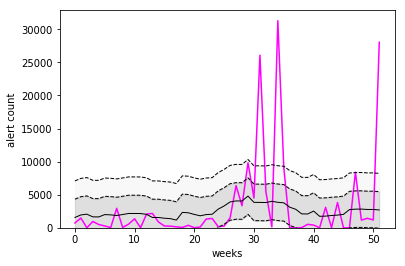

In [299]:
get_glads_plot(means, std, data)

# Dynamic Sentences


In [300]:
#Get most recent data and compare against statistical likelyhood.

recent_counts = data[-1].get('count')
mean = means[-1]

print(recent_counts, int(mean), int(std))

28045 2697 2763


In [301]:
yyyy = data[-1].get('year')
w = data[-1].get('week')

In [302]:
d = str(yyyy) + '-' + 'W' + str(w)
date = str(datetime.datetime.strptime(d + '-1', "%Y-W%W-%w"))[:10]
print(date)

2017-12-25


In [303]:
import colorama
from colorama import Fore


In [305]:
print(f"There were {recent_counts} GLADS alerts reported ", end="")
print(f"in the week of the '{date}', ", end="")

if (recent_counts > mean-std) and (recent_counts <= mean+std):
    print(f"which is ", end="")
    print(Fore.MAGENTA + f"similar ", end="")
    print(Fore.RESET + f"to the same week in previous years.", end="")
elif (recent_counts > mean+std) and (recent_counts <= mean+2*std):
    print(Fore.MAGENTA + f"higher ", end="")
    print(Fore.RESET + f"than the same week in previous years.", end="")    
elif (recent_counts > mean+2*std):
    print(Fore.MAGENTA + f"unusually high ", end="")
    print(Fore.RESET + f"compared to the same week in previous years.", end="")
elif (recent_counts < mean-std) and (recent_counts >= mean-2*std):
    print(Fore.MAGENTA + f"lower ", end="")
    print(Fore.RESET + f"than the same week in previous years.", end="")    
elif (recent_counts < mean-2*std):
    print(f"which is ", end="")
    print(Fore.MAGENTA + f"unusually low ", end="")
    print(Fore.RESET + f"compared to the same week in previous years.", end="")

There were 28045 GLADS alerts reported in the week of the '2017-12-25', unusually high compared to the same week in previous years.

### NOTE: the date in the above should be in the format "the 25th of December 2017"

### AND replace 'normal', 'higher/lower', and 'unusual' colour with GLADS colour palette (#D75B8E)